In [2]:
import kagglehub
import pandas as pd
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import os
import numpy as np

# --- Carregamento do Dataset Combinado Diretamente do Kaggle Hub ---
wine_dataset_slug = "ruthgn/wine-quality-data-set-red-white-wine"
wine_file_name = "wine-quality-white-and-red.csv"

# Carrega o arquivo CSV diretamente para um DataFrame do Pandas
df_raw_combined_wine = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    wine_dataset_slug,
    wine_file_name
)

# --- Salvando para Parquet (Boa prática para reusabilidade e performance) ---
output_dir = "data/processed"
os.makedirs(output_dir, exist_ok=True)
parquet_path = os.path.join(output_dir, "wine-quality-combined.parquet")

df_raw_combined_wine.to_parquet(parquet_path, engine="pyarrow", index=False)
print(f"DataFrame salvo com sucesso em formato Parquet: {parquet_path}")

/tmp/ipython-input-2-2451034981.py:19: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_raw_combined_wine = kagglehub.load_dataset(


DataFrame salvo com sucesso em formato Parquet: data/processed/wine-quality-combined.parquet


In [3]:
df_wine = pd.read_parquet(parquet_path)

print("\n--- Primeiras 5 linhas do DataFrame principal (carregado do Parquet) ---")
print(df_wine.head())

print("\n--- Informações gerais do DataFrame principal ---")
df_wine.info()

print("\n--- Verificando valores ausentes no DataFrame principal ---")
print(df_wine.isnull().sum())


--- Primeiras 5 linhas do DataFrame principal (carregado do Parquet) ---
    type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0  

In [4]:
df_processed_features = df_wine.copy()
df_processed_features = pd.get_dummies(df_processed_features, columns=['type'], drop_first=True, dtype=int)

print("\n--- Primeiras 5 linhas do DataFrame após One-Hot Encoding de 'type' ---")
print(df_processed_features.head())


--- Primeiras 5 linhas do DataFrame após One-Hot Encoding de 'type' ---
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  q

In [5]:
df_processed_features['good_quality'] = df_processed_features['quality'].apply(lambda x: 1 if x >= 6 else 0)
features_cols_no_engineering = df_processed_features.drop(['quality', 'good_quality'], axis=1).columns

X = df_processed_features[features_cols_no_engineering].copy()
y = df_processed_features['good_quality']

print(f"\nShape das Features (X) (SEM Engenharia de Features): {X.shape}")


Shape das Features (X) (SEM Engenharia de Features): (6497, 12)


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\n--- Primeiras 5 linhas das Features Escalonadas (X_scaled_df) (SEM Engenharia de Features) ---")
print(X_scaled_df.head())
print("\n--- Média e Desvio Padrão das Features Escalonadas (devem ser próximos de 0 e 1) ---")
print(X_scaled_df.describe().loc[['mean', 'std']])


--- Primeiras 5 linhas das Features Escalonadas (X_scaled_df) (SEM Engenharia de Features) ---
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.166089         -0.423183     0.284686        3.206929  -0.314975   
1      -0.706073         -0.240949     0.147046       -0.807837  -0.200790   
2       0.682458         -0.362438     0.559966        0.306208  -0.172244   
3      -0.011808         -0.666161     0.009406        0.642523   0.056126   
4      -0.011808         -0.666161     0.009406        0.642523   0.056126   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.815565              0.959976  2.102214 -1.359049  -0.546178   
1            -0.931107              0.287618 -0.232332  0.506915  -0.277351   
2            -0.029599             -0.331660  0.134525  0.258120  -0.613385   
3             0.928254              1.243074  0.301278 -0.177272  -0.882212   
4             0.928254              1.24

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_test: {y_test.shape}")

print("\n--- Proporção das classes em y_train (pré-SMOTE) ---")
print(y_train.value_counts(normalize=True))
print("\n--- Proporção das classes em y_test ---")
print(y_test.value_counts(normalize=True))

Shape de X_train: (5197, 12)
Shape de X_test: (1300, 12)
Shape de y_train: (5197,)
Shape de y_test: (1300,)

--- Proporção das classes em y_train (pré-SMOTE) ---
good_quality
1    0.633058
0    0.366942
Name: proportion, dtype: float64

--- Proporção das classes em y_test ---
good_quality
1    0.633077
0    0.366923
Name: proportion, dtype: float64


In [8]:
smote = SMOTE(random_state=42) # Usamos SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\n--- Shape de X_train após SMOTE ---")
print(X_train_resampled.shape)
print("\n--- Contagem de classes em y_train_resampled (após SMOTE) ---")
print(y_train_resampled.value_counts())


--- Shape de X_train após SMOTE ---
(6580, 12)

--- Contagem de classes em y_train_resampled (após SMOTE) ---
good_quality
1    3290
0    3290
Name: count, dtype: int64


In [9]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)

# Treinar com dados balanceados pelo SMOTE
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]


--- Relatório de Classificação (XGBoost) ---
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       477
           1       0.84      0.82      0.83       823

    accuracy                           0.79      1300
   macro avg       0.77      0.78      0.77      1300
weighted avg       0.79      0.79      0.79      1300


--- Matriz de Confusão (XGBoost) ---


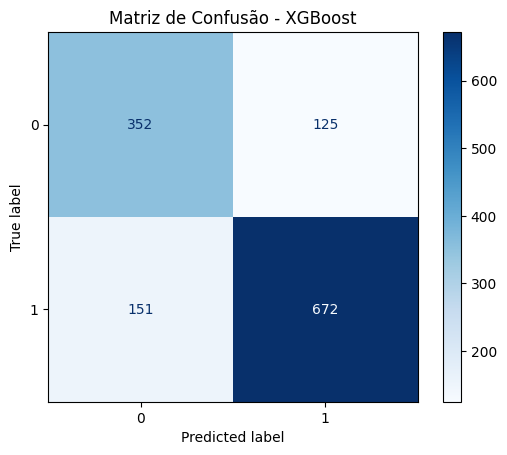

In [10]:
print("\n--- Relatório de Classificação (XGBoost) ---")
print(classification_report(y_test, y_pred))

print("\n--- Matriz de Confusão (XGBoost) ---")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - XGBoost')
plt.show()

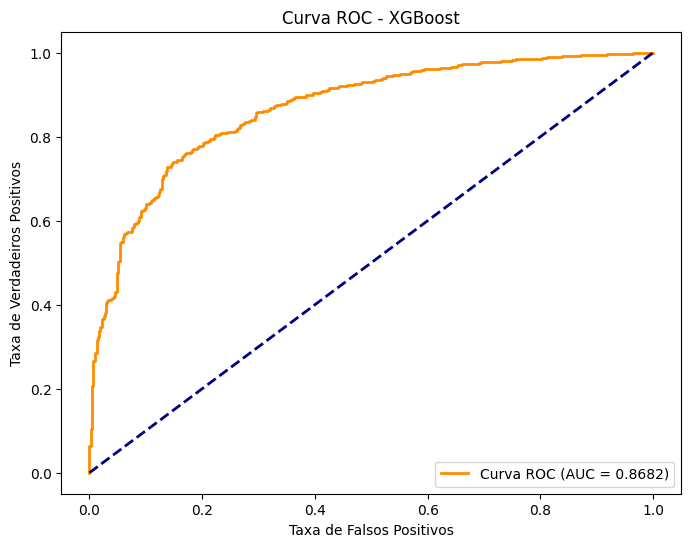

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - XGBoost')
plt.legend(loc="lower right")
plt.show()

<Figure size 1200x800 with 0 Axes>

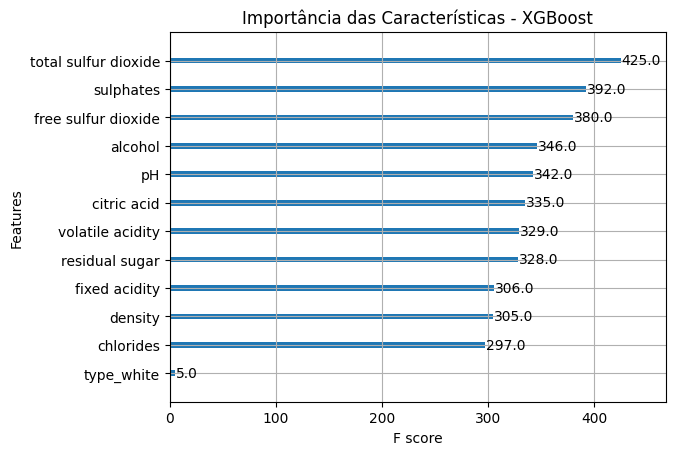

In [12]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=15, importance_type='weight')
plt.title('Importância das Características - XGBoost')
plt.show()

In [16]:
print(f"\n--- Resultados Gerais ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")


--- Resultados Gerais ---
Acurácia: 0.7877
Precisão: 0.8432
Recall: 0.8165
F1-Score: 0.8296
AUC-ROC: 0.8682
